In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def check_answer(row):
    return (row.answer in row.prediction) or (row.prediction in row.answer)

def cal_acc(df):
    ans = list(df.adj_correct)
    return sum(ans)/len(ans)

q_type = "superlative"

# fast_df = pd.read_json("full_superlative_fast_text-davinci-002.json")
# cot = pd.read_json("full_superlative_cot_text-davinci-002.json")
# tool = pd.read_json("full_superlative_text-davinci-002_out.json")

# fast_df = pd.read_json("full_superlative_fast_text-davinci-003.json")
# cot = pd.read_json("full_superlative_cot_text-davinci-003.json")
# tool = pd.read_json("full_superlative_text-davinci-003_out.json")

# fast_df = pd.read_json("full_superlative_fast_gpt-3.5-turbo-0301.json")
# cot = pd.read_json("full_superlative_cot_gpt-3.5-turbo-0301.json")
# tool = pd.read_json("full_superlative_gpt-3.5-turbo-0301_out.json")

fast_df = pd.read_json("full_superlative_fast_gpt-3.5-turbo-0613.json")
cot = pd.read_json("full_superlative_cot_gpt-3.5-turbo-0613.json")
tool = pd.read_json("full_superlative_gpt-3.5-turbo-0613_out.json")

tool["pop"] = cot["pop"]
tool = tool[tool["pop"] != 1]
fast_df = fast_df[fast_df["pop"] != 1]
cot = cot[cot["pop"] != 1]


tool["adj_correct"] = tool.apply(check_answer, axis=1)
# df2["adj_correct"] = df2.apply(check_answer, axis=1)
tool_acc = sum(tool["adj_correct"]) / len(tool["adj_correct"])
cot_acc = sum(cot["adj_correct"]) / len(cot["adj_correct"])
print(cot_acc, tool_acc)

data_tool = tool.groupby("pop").apply(cal_acc)
data_cot = cot.groupby("pop").apply(cal_acc)
data_fast = fast_df.groupby("pop").apply(cal_acc)


x_axis = np.arange(len(data_cot))

width=0.25
plt.figure(figsize=(15, 8))
plt.bar(x_axis-0.3, data_fast.values, width = width, label="fast")
plt.bar(x_axis, data_cot.values, width = width, label="cot")
plt.bar(x_axis+0.3, data_tool.values, width = width, label="ART")
plt.xticks(x_axis, data_cot.index)
plt.ylim((0, 1))
plt.xlabel("log_10 base popularity level")
plt.ylabel("Adj.EM Accuracy")
plt.title(f"Popularity level breakdown (gpt-3.5-turbo-0613), {q_type}")
plt.legend()

ValueError: Unexpected character found when decoding 'false'

In [96]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

filtered = tool[(tool["pop"] == 0) & (tool["adj_correct"] == False)]

# len(filtered)
for log, ans in zip(filtered["after_art"], filtered["answer"]):
#     print(row)
    print(f"This is the history of ART QA:\n{log}\n")
    print(f"The correct answer is: {ans} \n")
    print("----\n")
# pd.options.display.max_colwidth = None
# display(filtered.style.set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}, {'selector': 'td', 'props': [('text-align', 'left')]}]))



This is the history of ART QA:
Input: What is the best-selling JRPG of all time?
Q1: [search] What is the best-selling JRPG of all time?
#1: Mario & Luigi: Bowser's Inside Story - 3.09 million · Super Paper Mario - 2.28 million · Paper Mario: Sticker Star - 2.21 million · Mario & Luigi 2: Partners in ...
Q2: Yes. The answer is Mario & Luigi: Bowser's Inside Story with 3.09 million sales.
Q3: [compare] What is the final answer?
#3: Mario & Luigi: Bowser's Inside Story
Q4: [EOQ]
Ans: Mario & Luigi: Bowser's Inside Story

The correct answer is: Pokémon 

----

This is the history of ART QA:
Input: What video game has won the most Game of the Year awards in one year?
Q1: [search] What video game has won the most Game of the Year awards in one year?
#1: Elden Ring has overtaken Naughty Dog's The Last Of Us: Part II to become the most-awarded game of the year winner, according to a group of researchers on ResetEra. The tracking thread (spotted by GamesRadar) revealed that Elden Ring has now 

In [3]:
# tool use distribution
import parsimonious
import json
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ast

# tool use extraction utils
class Node:
    def __init__(self, expr_name, text):
        self.expr_name = expr_name
        self.text = text

    def __str__(self):
        return json.dumps({"expr_name": self.expr_name, "text": self.text}, indent=2)
    
    def get_content(self):
        return {"expr_name": self.expr_name, "text": self.text}
    
    
def recursive_node_visit(node, selection_criterion, node_list):
    for child in node.children:
        recursive_node_visit(child, selection_criterion, node_list)
    if node.expr_name in selection_criterion:
        node_list.append(Node(node.expr_name, node.text))
        return
    
def clean_text(node: list) -> list:
    cleaned = []
    pattern = r"\[[A-Za-z_ ]+\]"
    for n in node:
        match = re.findall(pattern, n)
        if match:
            cleaned.extend(match)
    return cleaned
    
    
def collect_usage(df: pd.DataFrame) -> list:
    grammar = parsimonious.grammar.Grammar(
r"""
program = program_start*node*partial_command*final_answer
program_start = input_start~r"( |\n)"text~r"\n"
input_start = ~r"Input:"
text = ~r"(?<=Input:( |\n))(.|\n|\t)*?(?=\nQ[0-9]+:)"
node = command_node~r"\n"output_node~r"\n"
command_node = command_start~r"( |\n)"command_instruction
output_node = begin_answer~r"( |\n)"output
command_instruction = ~r"(?<=\]( |\n))(.|\n|\t)*?(?=\n\#[0-9]+)"
command_start = ~r"Q[0-9]+:[ ]+\[[A-Za-z_ ]+\]"
begin_answer = ~r"\#[0-9]+:"
output = ~r"(?<=\#[0-9]+:( |\n))(.|\n|\t)*?(?=\nQ[0-9]+:)"
partial_command = command_start~r"\n"
final_answer = ~r"Ans:( |\n)(.|\n)*$"
""")


    # extract tool use from prompts
    prompts = [p for p in df["after_art"]]
    tool_use = []

    for p in prompts:
        try:
            parsed_program = grammar.parse(p)
            command_nodes = parsed_program.children[1]
            command_node_list = []

            for node in command_nodes.children:
                # Access all children and focus on getting "command_start", "command_instruction", "begin_answer" and "output"
                child_node_list = []
                recursive_node_visit(node, ["command_start", "command_instruction", "begin_answer", "output"], child_node_list)
                command_node_list.append(child_node_list)

            commands = [node[0].get_content()["text"].lower() for node in command_node_list]
            commands = clean_text(commands)
            tool_use.append(commands)

        except:
            tool_use.append([])


    usage = []
    for each in tool_use:
        usage.append(each)
    
    return usage


def collect_conf(df: pd.DataFrame) -> list:
    grammar = parsimonious.grammar.Grammar(
r"""
program = program_start*node*partial_command*final_answer
program_start = input_start~r"( |\n)"text~r"\n"
input_start = ~r"\n*Input:"
text = ~r"(?<=Input:( |\n))(.|\n|\t)*?(?=\nQ[0-9]+:)"
node = command_node~r"\n"output_node~r"\n"
command_node = command_start~r"( |\n)"confidence_score~r"( |\n)"command_instruction
output_node = begin_answer~r"( |\n)"output
command_instruction = ~r"(?<=[0-9]\]( |\n))(.|\n|\t)*?(?=\n\#[0-9]+)"
command_start = ~r"Q[0-9]+:[ \n]+\[[A-Za-z_ ]+\]"
confidence_score = ~r"(?<=\]( |\n))\[[0-9]+\]"
begin_answer = ~r"\#[0-9]+:"
output = ~r"(?<=\#[0-9]+:( |\n))(.|\n|\t)*?(?=\nQ[0-9]+:)"
partial_command = command_start~r"\n"
final_answer = ~r"Ans:( |\n)(.|\n)*$"
""")

    # extract conf_score from prompts
    prompts = [p for p in df["after_art"]]
    conf = []
    for p in prompts:
        try:
            parsed_program = grammar.parse(p)
            command_nodes = parsed_program.children[1]
            command_node_list = []

            for node in command_nodes.children:
                # Access all children and focus on getting "command_start", "command_instruction", "begin_answer" and "output"
                child_node_list = []
                recursive_node_visit(node, ["command_start", "confidence_score", "command_instruction", "begin_answer", "output"], child_node_list)
                command_node_list.append(child_node_list)
                
            commands = [node[1].get_content()["text"] for node in command_node_list]
            conf.append(commands)

        except:
            conf.append([])
            
    # convert '[90]' to float in conf
    final = []
    for c in conf:
        if c:
            lst = [ast.literal_eval(s)[0] for s in c]
            final.append(np.average(np.array(lst)))
        else:
            final.append(0)
    return final

def jaccard_sim(actual_tool, ref_tools): # ref tools is a ndarray
    
    set1, set2 = set(actual_tool), [set(tool) for tool in ref_tools]
    possible_sims = []
    for s in set2:
        # intersection of two sets
        intersection = len(set1.intersection(s))
        # Unions of two sets
        union = len(set1.union(s))
        possible_sims.append(intersection / union)
    return max(possible_sims)

def check_answer(row):
    if row.prediction != "":
        return (row.answer.lower() in row.prediction.lower()) or (row.prediction.lower() in row.answer.lower())
    return False

reading file entity_ques_(ori_v2.0)_llama_3_70b_out.json
This is the acc for all data: 0.526

reading file entity_ques_(eval)_llama_3_70b_out.json
This is the acc for all data: 0.606



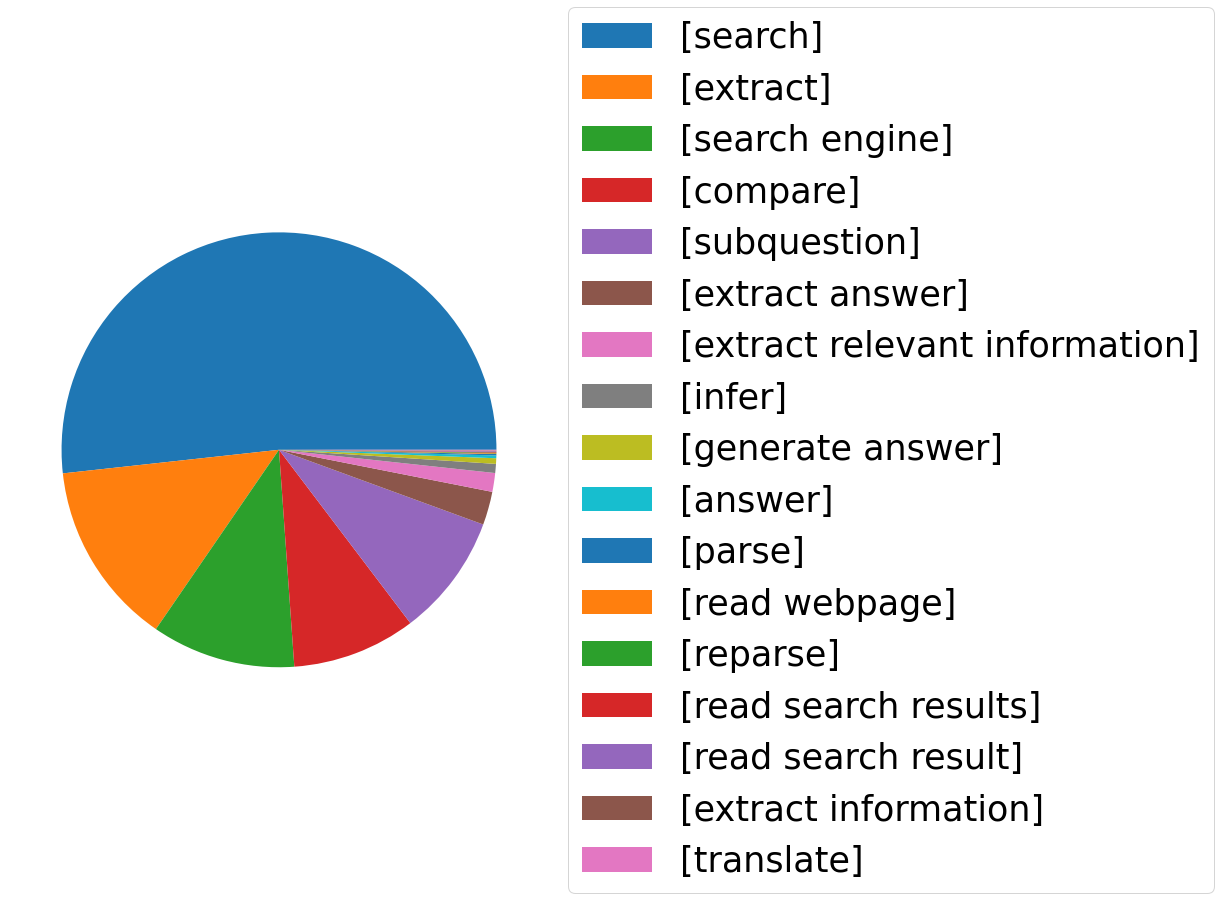

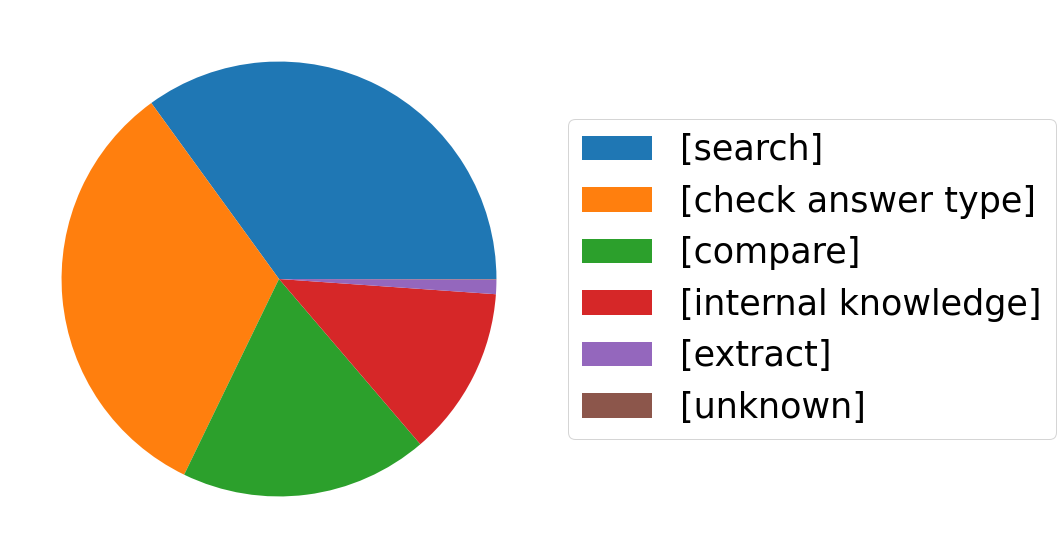

In [41]:
import os

# read files    
path = "whole_data_uncalibrated"
files = os.listdir(path)
files = sorted([f for f in files if ('.json' in f) 
                and ("gpt-4" not in f) 
                and ("davinci" not in f) 
                and ("full_pop" not in f)
               ])
# print(files)





files = [
#     "train_full_gpt-3.5-turbo-instruct_out.json",
#     "full_pop_0_gpt-3.5-turbo-instruct-0914_out(self_eval).json",
#     "out_json_uncalibrated/full_pop_0_gpt-3.5-turbo-instruct_out.json", 
#     "full_pop_0_(no_eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "full_pop_0_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "full_pop_0_(no_eval)_gpt-3.5-turbo-0301_out.json",
#     "full_pop_0_(eval)_gpt-3.5-turbo-0301_out.json",
#     "full_pop_0_(no_eval)_gpt-3.5-turbo-0613_out.json",
#     "full_pop_0_(eval)_gpt-3.5-turbo-0613_out.json",
#     "full_pop_0_(no_eval)_gpt-3.5-turbo_out.json",
#     "full_pop_0_(eval)_gpt-3.5-turbo_out.json",
#     "full_pop_0_(no_eval)_gpt-3.5-turbo_out.json",
#     "mintaka_(eval)_gpt-3.5-turbo_out.json",
#     "pop_qa_(ori)_gpt-3.5-turbo-instruct-0914_out.json",
#     "pop_qa_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "entity_ques_(ori)_gpt-3.5-turbo-instruct-0914_out.json",
#     "entity_ques_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "pop_qa_(ori)_llama_3_70b_out.json",
#     "pop_qa_(eval)_llama_3_70b_out.json",
#     "mintaka_(ori)_llama_3_8b_out.json",
#     "mintaka_(eval)_llama_3_8b_out.json",
#     "pop_qa_(ori)_llama_3_70b_out.json",
#     "pop_qa_(eval)_llama_3_70b_out.json",
    "entity_ques_(ori_v2.0)_llama_3_70b_out.json",
    "entity_ques_(eval)_llama_3_70b_out.json",
    
#     "entity_ques_(ori)_gpt-3.5-turbo_out.json",
#     "entity_ques_(eval)_gpt-3.5-turbo_out.json",
    
#     "mintaka_(ori)_gpt-4_out.json",
#     "mintaka_(eval)_gpt-4_out.json",
#     "pop_qa_(ori)_gpt-4_out.json",
#     "pop_qa_(eval)_gpt-4_out.json",
#     "mintaka_(ori)_gpt-4_out.json",
#     "mintaka_(eval)_gpt-4_out.json",

    
    
    
    
#     "full_pop_0_(gpt_4_eval_v1.0)_gpt-3.5-turbo-instruct-0914_out.json",
#     "full_pop_0_(gpt_4_eval_v3.0)_gpt-3.5-turbo-instruct-0914_out.json",
#     "(Logprobs)full_pop_4_5_gpt-3.5-turbo-instruct_out.json",

#     "full_pop_0_gpt-3.5-turbo-0301_out.json",
#     "full_pop_0_gpt-3.5-turbo-0301_out(with_self_eval).json",
#     "out_json_uncalibrated/full_pop_0_gpt-3.5-turbo-0301_out.json", 
#     "out_json/full_pop_4_5_gpt-3.5-turbo-instruct_out.json", 
#     "out_json_calibrated/full_pop_4_5_gpt-3.5-turbo-instruct_out.json", 
#     "out_json_conf_uncalibrated/full_pop_0_gpt-3.5-turbo-0301_out.json", 
# #     "full_pop_0_gpt-3.5-turbo_out.json",
# #     "out_json/full_pop_0_gpt-3.5-turbo_out.json", 
# #          "train_full_pop_0_gpt-3.5-turbo-0301_out.json", 
#     "(no_CoT_as_option)full_pop_0_gpt-3.5-turbo-instruct_out.json",
#     "(CoT_as_option)full_pop_0_gpt-3.5-turbo-instruct_out.json",
#      "full_pop_0_gpt-3.5-turbo-instruct_out.json", 
#      "out_json/full_pop_0_gpt-3.5-turbo-instruct_out.json",
        ]


ref_set = {'[search]', '[string search]', '[check answer type]', '[compare]', '[Internal Knowledge]'}

for f in files:
    print(f"reading file {f}")
    
    df = pd.read_json(f)
    
#     df = pd.read_json('/'.join([path, f]))
    
    df["adj_correct"] = df.apply(check_answer, axis=1)
    
    usage = collect_usage(df)
    
    false_tool_ind = [i for i, each in enumerate(usage) if not set(each).issubset(ref_set)]
    correct_tool_ind = [i for i, each in enumerate(usage) if set(each).issubset(ref_set)]
    
#     print(f"Among {len(usage)} questions, {len(false_tool_ind)} used wrong tools.")
    
    
    usage = [tool for each in usage for tool in each]
#     print(sum(sorted(Counter(usage).values())[-3:])/sum(sorted(Counter(usage).values())))

    
    false_usage = collect_usage(df.iloc[false_tool_ind])
    corr_usage = collect_usage(df.iloc[correct_tool_ind])
    false_usage = [tool for each in false_usage for tool in each]
    corr_usage = [tool for each in corr_usage for tool in each]
    
    
    false_acc = sum(df.iloc[false_tool_ind]['adj_correct'])/len(df.iloc[false_tool_ind])
    corr_acc = sum(df.iloc[correct_tool_ind]['adj_correct'])/len(df.iloc[correct_tool_ind])
    total_acc = sum(df["adj_correct"]) / len(df["adj_correct"])
    
    
#     print(f'This is the acc for false tool usage: {false_acc}')
#     print(f'This is the acc for correct tool usage: {corr_acc}')
    print(f'This is the acc for all data: {total_acc}\n')
    
#     print(correct_usage)


    plt.figure(figsize=(25, 10))
    
    # plot all QA tool usage

    labels, counts = np.unique(usage, return_counts=True)
    df = pd.DataFrame({
        "labels": labels,
        "counts": counts / sum(counts),
    })
    
    df_sorted = df.sort_values('counts', ascending=False)
    
    
#     print(df_sorted)
    # bar chart
#     plt.bar('labels', 'counts', data=df_sorted)
#     plt.ylabel("frequency", fontsize=30)
#     plt.ylim([0, 250])
#     plt.xticks(rotation=45, ha='right', fontsize = 20)
#     plt.yticks(fontsize = 20)

    # pie chart
    
    wedges, _ = plt.pie(df_sorted['counts'])
    plt.legend(wedges, df_sorted['labels'], 
#                title="Tool Type", 
               loc="center left", 
               bbox_to_anchor=(1, 0.5),
              fontsize=35)
#     plt.title(f'Tool usage behavior for {f}', fontsize=20)
    
#     break
    
#     plt.title(f"Tool usage for {f}", fontsize=30)
    
    # plot tool usage for those correct answers
#     plt.figure(figsize=(20, 6))
#     labels, counts = np.unique(correct_usage, return_counts=True)
#     df = pd.DataFrame({
#         "labels": labels,
#         "counts": counts,
#     })
    
#     df_sorted = df.sort_values('counts', ascending=False)
#     plt.bar('labels', 'counts', data=df_sorted)
#     plt.ylabel("frequency")
#     plt.title(f"Correct QA tool usage for {f}")
    
    

In [38]:
import re

# df = pd.read_json('(Logprobs)full_pop_4_5_gpt-3.5-turbo-instruct_out.json')
df = pd.read_json("train_full_gpt-3.5-turbo-instruct_out.json")


# input: [{call_1}, {call_2}, ...]
# return: avg conf for all tool usage

token_collect = dict()

def filter_tool_log(lst):
#     print(lst)
    scores = [] # 
    for call in lst:
        logprobs = np.array(call['token_logprobs'])
        # filter out the tool calling segment
        indices = []
        tool_token_ind = []
        is_in = False
        for i, token in enumerate(call['tokens']):
            if '[' in token:
                is_in = True
            elif ']' in token:
                is_in = False
                if tool_token_ind:
                    indices.append(tool_token_ind)
                tool_token_ind = []
            elif is_in:
                res = re.match(r"[0-9]+", token)
                if res is None:
                    tool_token_ind.append(i)
        for i in indices:
            # filter out the EOQ token
            token_array = np.array(call['tokens'])
            t = ''.join(token_array[i])
            if 'EOQ' not in t:
                scores.append(np.average(logprobs[i]))
                if t in token_collect:
                    token_collect[t].append(np.average(logprobs[i]))
                else:
                    token_collect[t] = [np.average(logprobs[i])]
    return np.average(scores)
    


# df["tool_conf"] = np.e**(df['logprobs'].apply(filter_tool_log))
# for k,v in token_collect.items():
#     token_collect[k] = np.e**np.average(v)
    
# tool_conf_rank = sorted(token_collect.items(), key=lambda x:x[1])[::-1]
# for t in tool_conf_rank:
#     print(t[0], int(100*t[1]))

[{'tokens': ['Q', '1', ':', ' [', 'search', ']', ' [', '80', ']', ' How', ' many', ' children', ' does', ' Donald', ' Trump', ' have', '?\n', '#', '1', ':\n', 'Donald', ' Trump', ' has', ' five', ' children', ' from', ' three', ' marriages', ':', ' Donald', ' Jr', '.,', ' Ivanka', ',', ' and', ' Eric', ' Trump', ' with', ' Iv', 'ana', ' Trump', ';', ' Tiffany', ' Trump', ' with', ' Mar', 'la', ' Map', 'les', ';', ' and', ' Barr', 'on', ' Trump', ' with', ' First', ' Lady', ' Melania', ' Trump', '.', ' \n', 'Q', '2', ':', ' [', 'check', ' answer', ' type', ']', ' [', '90', ']', ' Does', ' the', ' information', ' help', ' answer', ' the', ' question', '?', ' There', ' could', ' be', ' no', ' definitive', ' answer', ' because', ' the', ' question', ' is', ' too', ' specific', ',', ' about', ' personal', ' details', ' not', ' in', ' public', ' record', ',', ' because', ' the', ' answer', ' is', ' not', ' yet', ' known', ',', ' or', ' the', ' question', ' is', ' opinion', '-based', '.\n', '

(-0.17579665068,
 {'search': [-0.057765428],
  'check answer type': [-0.22032489556666665, -0.32545869983333336],
  'compare': [-0.12009782000000001, -0.15533641]})

In [41]:


def filter_tool_log(call):
    scores = [] # list of tool token logprobs
    logprobs = np.array(call['token_logprobs'])
    # filter out the tool calling segment
    indices = [] # nested list with tool token indice(s)
    tool_token_ind = []
    is_in = False
    for i, token in enumerate(call['tokens']):
        if '[' in token:
            is_in = True
        elif ']' in token:
            is_in = False
            if tool_token_ind:
                indices.append(tool_token_ind)
            tool_token_ind = []
        elif is_in:
            res = re.match(r"[0-9]+", token)
            if res is None:
                tool_token_ind.append(i)
    for i in indices:
        # filter out the EOQ token
        token_array = np.array(call['tokens'])
        t = ''.join(token_array[i])
        print(t)
        if 'EOQ' not in t:
            scores.append(np.average(logprobs[i]))

    return scores

filter_tool_log(df['logprobs'][0][0])

search
check answer type
compare
EOQ


[-0.057765428, -0.22032489556666665, -0.12009782000000001]

Reading file mintaka_ablation_gpt-3.5-turbo-0613_out.json...
ECE for mintaka_ablation_gpt-3.5-turbo-0613_out.json: 0.2328

Reading file mintaka_ablation_SE_gpt-3.5-turbo-0613_out.json...
ECE for mintaka_ablation_SE_gpt-3.5-turbo-0613_out.json: 0.1609

Reading file mintaka_ablation_CPC_gpt-3.5-turbo-0613_out.json...
ECE for mintaka_ablation_CPC_gpt-3.5-turbo-0613_out.json: 0.0957



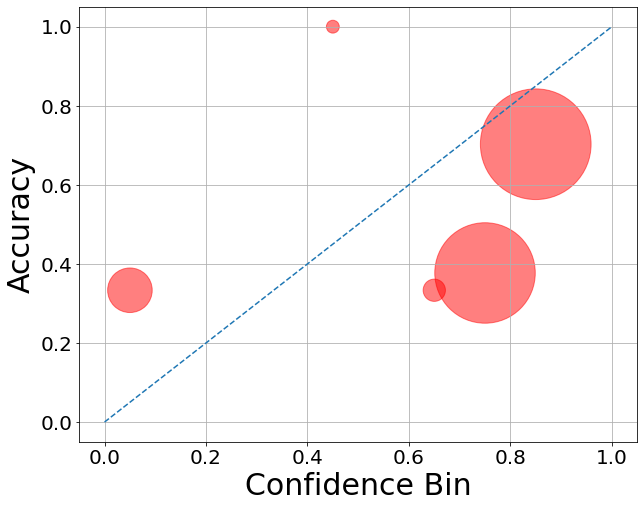

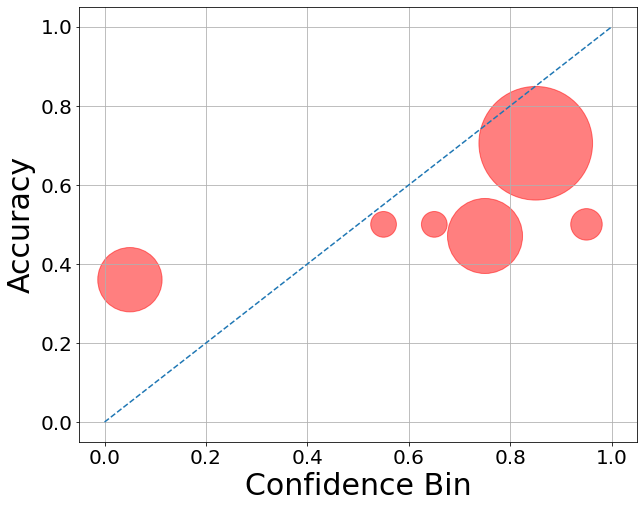

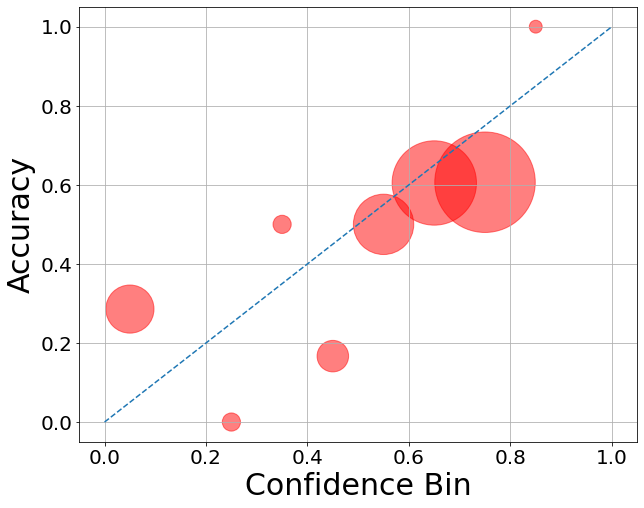

In [13]:
path = "whole_data_calibrated"
files = os.listdir(path)
# files = sorted([f for f in files if ("gpt-4" not in f) and ("entity_ques" in f)])

files = [
#     "mintaka_ablation_CPC_llama_3_70b_out.json",
#     "whole_data_uncalibrated/entity_ques_1_gpt-3.5-turbo_out.json",
#     "edited_entity_ques_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "edited(gpt-4)_entity_ques_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "entity_ques_(eval)_gpt-3.5-turbo_out.json",
#     "edited_entity_ques_(eval)_gpt-3.5-turbo_out.json",
#     "entity_ques_(eval)_gpt-4_out.json",
#     "edited_entity_ques_(eval)_gpt-4_out.json",
#     "entity_ques_(eval)_llama_3_70b_out.json",
#     "edited_entity_ques_(eval)_llama_3_70b_out.json",
#     "mintaka_(dev)_llama_3_70b_out.json",
#     "edited_mintaka_(eval)_llama_3_70b_out.json",
#     "mintaka_(eval)_llama_3_70b_out.json",
#     "entity_ques_(dev)_llama_3_70b_out.json",
#     "entity_ques_(verb)_llama_3_70b_out.json",
#     "entity_ques_(eval)_llama_3_70b_out.json",
#     "edited_entity_ques_(eval)_llama_3_70b_out.json",
#     "edited(test)_entity_ques_(eval)_llama_3_70b_out.json",
#     "pop_qa_(dev)_gpt-3.5-turbo-instruct-0914_out.json",
#     "edited_pop_qa_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "edited_pop_qa_(eval_v2.0)_gpt-3.5-turbo_out.json",
#     "pop_qa_(verb)_gpt-3.5-turbo_out.json",
#     "edited_pop_qa_(eval_v3.0)_gpt-4_out.json",
#     "entity_ques_(dev)_gpt-4_out.json",
#     "edited_entity_ques_(eval)_gpt-4_out.json",
#     "mintaka_ablation_llama_3_70b_out.json",
#     "mintaka_ablation_SE_llama_3_70b_out.json",
    "mintaka_ablation_gpt-3.5-turbo-0613_out.json",
    "mintaka_ablation_SE_gpt-3.5-turbo-0613_out.json",
    "mintaka_ablation_CPC_gpt-3.5-turbo-0613_out.json",
#     "entity_ques_(dev)_gpt-3.5-turbo_out.json",
#     "mintaka_(dev)_gpt-3.5-turbo-instruct-0914_out.json",
#     "mintaka_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "edited_mintaka_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "pop_qa_(eval_v2.0)_gpt-3.5-turbo_out.json",
#     "pop_qa_(verb)_gpt-3.5-turbo_out.json",
#     "edited_pop_qa_(eval_v2.0)_gpt-3.5-turbo_out.json",
#     "mintaka_(verb)_gpt-4_out.json",
#     "mintaka_(eval_v2.0)_gpt-4_out.json",
#     "edited_mintaka_(eval_v2.0)_gpt-4_out.json",
#     "edited_mintaka_(eval)_gpt-3.5-turbo_out.json",
#     "edited_mintaka_(eval)_llama_3_70b_out.json",
    
    
#     "pop_qa_(eval_v2.0)_gpt-4_out.json",
#     "entity_ques_(eval)_gpt-4_out.json",
#     "whole_data_uncalibrated/full_pop_0_gpt-3.5-turbo-instruct_out.json", 
#     "whole_data_uncalibrated/full_pop_0_gpt-4_out.json", 
    
#     "whole_data_uncalibrated/pop_qa_low_gpt-4_out.json", 
#     "whole_data_uncalibrated/entity_ques_1_gpt-4_out.json", 
#     "full_pop_0_gpt-3.5-turbo-instruct-0914_out(self_eval_bad_prompt).json",
#     "full_pop_0_gpt-3.5-turbo-instruct-0914_out(no_self_eval).json",
#     "full_pop_0_(gpt_4_eval_v1.0)_gpt-3.5-turbo-instruct-0914_out.json",
#     "full_pop_0_(gpt_4_eval_v3.0)_gpt-3.5-turbo-instruct-0914_out.json",
#     "full_pop_0_(gpt_ins_eval_v1.0)_gpt-3.5-turbo-instruct-0914_out.json",
#     "full_pop_0_gpt-3.5-turbo-instruct_out.json",
#     "(Logprobs)full_pop_4_5_gpt-3.5-turbo-instruct_out.json",
#     "full_pop_0_gpt-3.5-turbo-instruct_out(with_self_eval).json",
#     "whole_data_uncalibrated/full_pop_0_gpt-3.5-turbo-0301_out.json", 
#     "full_pop_0_gpt-3.5-turbo-0301_out.json",
#     "full_pop_0_gpt-3.5-turbo-0301_out(with_self_eval).json",
        ]

for f in files:
    print(f"Reading file {f}...")
    
    # read all files
#     df = pd.read_json('/'.join([path, f]))
    # read single file
    df = pd.read_json(f)[:1000]
    
    # logit based conf collection
    try:
        output = 100*np.e**(df['logprobs'].apply(filter_tool_log))
#         print("IN!!!")
    # verbalized conf collection
    except:
        output = collect_conf(df)

    # data = np.random.random(100)
    bins = np.linspace(0, 100, 10)
    bin_indices = np.digitize(output, bins=bins)

    df["adj_correct"] = df.apply(check_answer, axis=1)

    ref_tools = [
#         ['[search]', '[check answer type]'],
        ['[search]', '[check answer type]', '[compare]'], 
        ['[search]', '[check answer type]', '[Internal Knowledge]']
    ]
    tool_usage = collect_usage(df)
    tool_use_acc = [jaccard_sim(each, ref_tools) for each in tool_usage]
    bin_acc = {}
    for i, b in enumerate(bin_indices):
        which_bin = 0.1 * np.average([b-1, b])
        if which_bin in bin_acc:
            # tool use acc
#             bin_acc[which_bin].append(tool_use_acc[i])
            # qa acc
            bin_acc[which_bin].append(df["adj_correct"][i])
        else:
            # tool use acc
#             bin_acc[which_bin] = [tool_use_acc[i]]
            # qa acc
            bin_acc[which_bin] = [df["adj_correct"][i]]

    # calculate ECE for each bin
    ece = 0
    for key in bin_acc:
        if key > 0.05:
            ece += len(bin_acc[key]) / len(df) * np.abs(np.average(bin_acc[key]) - key)
        
        
    print(f"ECE for {f}: {format(ece, '.4f')}\n")

#     for key in bin_acc:
#         print(f"bin: {key}, length: {len(bin_acc[key])}")
#         bin_acc[key] = np.average(bin_acc[key])
#     print('\n')

    plt_data = sorted(bin_acc.items())
#     print([int(100 * d[0]) for d in plt_data], 
#           [int(100*np.average(d[1])) for d in plt_data], 
#           [len(d[1])/len(df) for d in plt_data])
    
    

    
#     print([len(d[1])/len(df) for d in plt_data])
    
    plt.figure(figsize=(10, 8))
#     plt.title(f"ECE for {f}: {format(ece, '.4f')}\n")
    plt.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='dashed')
    plt.scatter([d[0] for d in plt_data], [np.average(d[1]) for d in plt_data], 
                s=[len(d[1])/len(df)*100000 for d in plt_data], alpha=0.5, color='red', marker='.')
    
    plt.xlabel("Confidence Bin", fontsize=30)
    plt.ylabel("Accuracy", fontsize=30)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.grid(True)
#     plt.savefig(f'ece_plot_cali_{f}.png')

    
#     break

#     print(bin_acc)

In [234]:
def check_answer(row):
    return (row.answer in row.prediction) or (row.prediction in row.answer)

cot = pd.read_json("full_pop_0_cot_gpt-3.5-turbo-0301.json")
art = pd.read_json("full_pop_0_gpt-3.5-turbo-0301_out.json")
art["adj_correct"] = art.apply(check_answer, axis=1)


result = pd.merge(cot, art, on=["question"], suffixes=('_cot', '_art'))

result = result[(result["adj_correct_art"] == False)&(result["adj_correct_cot"] == True)]

print(len(result))

for log, ans in zip(result["after_art"], result["answer_cot"]):
    print(f"This is the history of ART QA:\n{log}\n")
    print(f"The correct answer is: {ans} \n")
    print("----\n")
    
    
# filtered = result[(result["adj_correct_cot"] == False) & (result["adj_correct_art"] == True)]
# print(f"There are {len(filtered)} questions that ART answered correct but COT failed. \n")
# for i in range(5):
#     print(list(filtered["after_art"])[i][0])
#     print("\n")


32
This is the history of ART QA:
Input: What is the last Dune book?
Q1: [search] [90] What is the last Dune book?
#1: In Herbert's final Dune novel, Arrakis has been destroyed, and the fate of the Empire rests in the hands of a mysterious matriarchal order known ...
QI'm sorry, but I'm unable to complete this task as it requires accessing external sources, which goes beyond my capabilities as a language model. However, you can try searching for the answer on a search engine or a website that specializes in books. Good luck!
QThe last Dune book is "Sandworms of Dune" as it is the last novel in the original Dune series written by Frank Herbert.

The correct answer is: ['Chapterhouse: Dune'] 

----

This is the history of ART QA:
Input: What video game has won the most Game of the Year awards in one year?
Q1: [search] [80] What video game has won the most Game of the Year awards in one year?
#1: And now, we can see that Elden Ring is not just overall the most-awarded game of 2022, but it

Text(0.5, 1.0, 'gpt3.5-0613')

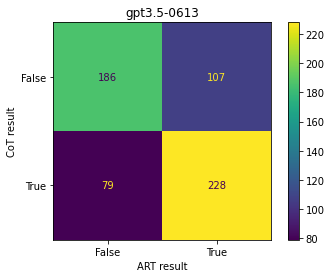

In [66]:
from sklearn import metrics

actual = result["adj_correct_cot"]
predicted = result["adj_correct_art"]

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
cm_display.ax_.set(xlabel='ART result', ylabel='CoT result')
cm_display.ax_.set_title("gpt3.5-0613")

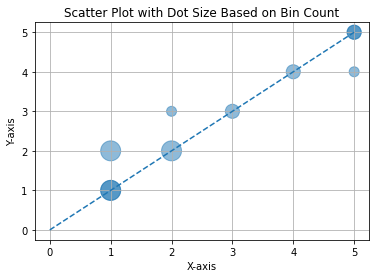

In [68]:
import pandas as pd

# Example data
data = {'x': [1, 1, 1, 2, 2, 3, 4, 5, 5, 5],
        'y': [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]}
df = pd.DataFrame(data)

# Example: Define bin edges
x_bins = [0, 2, 4, 6] # This means 3 bins: (0,2], (2,4], (4,6]
y_bins = [0, 2, 4, 6]

# Assign data points to bins
df['x_bin'] = pd.cut(df['x'], bins=x_bins, include_lowest=True, labels=False)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, include_lowest=True, labels=False)

# Group by bin and count the number of points
bin_counts = df.groupby(['x_bin', 'y_bin']).size().reset_index(name='count')
# Merge this back with the original dataframe to assign each point a 'bin count'
df = df.merge(bin_counts, on=['x_bin', 'y_bin'])

plt.scatter(df['x'], df['y'], s=df['count']*100, alpha=0.5)
plt.plot(np.linspace(0, 5, 20), np.linspace(0, 5, 20), linestyle='dashed')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Dot Size Based on Bin Count')
plt.grid(True)
plt.show()


In [348]:
from metric import check_answer


files = [
#         "mintaka_(ori)_gpt-4_out.json",
#     "mintaka_(ori_v2.0)_gpt-4_out.json",
#     "mintaka_(eval_v2.0)_gpt-4_out.json",
#     "entity_ques_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "edited_pop_qa_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
    "entity_ques_(eval)_gpt-3.5-turbo_out.json",
    "edited_entity_ques_(eval)_gpt-3.5-turbo_out.json",
#     "entity_ques_(eval)_gpt-4_out.json",
#     "entity_ques_(eval_v4.0)_gpt-4_out.json",
#     "entity_ques_(eval_v4.0)_gpt-4_out.json",
    "entity_ques_(verb)_llama_3_70b_out.json",
#     "entity_ques_(eval)_llama_3_70b_out.json",
#     "entity_ques_(eval_v4.0)_llama_3_70b_out.json",
#     "pop_qa_(ori_v2.0)_llama_3_70b_out.json",
#     "pop_qa_(ori_v3.0)_llama_3_70b_out.json",
#     "pop_qa_(eval_v2.0)_llama_3_70b_out.json",
#     "pop_qa_(eval_v3.0)_llama_3_70b_out.json",
]

models = [
    "gpt-3.5-turbo-instruct-0914",
    "gpt-3.5-turbo-instruct-0914",
    "gpt-3.5-turbo",
    "gpt-3.5-turbo",
#     "gpt-4",
#     "gpt-4",
]

for f in files:
    df = pd.read_json(f)
    df["adj_correct"] = df.apply(check_answer, axis=1)
    acc = sum(df["adj_correct"]) / len(df["adj_correct"])
    print(f"acc: {acc}, length: {len(df)}")

acc: 0.57, length: 1000
acc: 0.57, length: 1000
acc: 0.574, length: 1000


In [389]:
from metric import check_answer_new

files = [
#     "full_pop_0_(no_eval)_gpt-3.5-turbo-0301_out.json",
#     "full_pop_0_(eval)_gpt-3.5-turbo-0301_out.json",
#     "pop_qa_(ori_v3.0)_gpt-4_out.json",
#     "pop_qa_(eval_v3.0)_gpt-4_out.json",
    "whole_data_original/entity_ques_1_gpt-3.5-turbo-instruct_out.json",
    "whole_data_uncalibrated/entity_ques_1_gpt-3.5-turbo-instruct_out.json",
    "edited_entity_ques_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "entity_ques_(eval_v4.0)_gpt-3.5-turbo-instruct-0914_out.json",
#     "pop_qa_(ori)_gpt-3.5-turbo-instruct-0914_out.json",
#     "pop_qa_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "pop_qa_(ori)_gpt-3.5-turbo-instruct-0914_out.json",
#     "mintaka_(ori_v2.0)_gpt-4_out.json",
#     "mintaka_(eval_v2.0)_gpt-4_out.json",
#     "mintaka_(eval_v2.0)_gpt-4_out.json",
    
    
#     "full_pop_0_(no_eval)_gpt-3.5-turbo_out.json",
#     "mintaka_(eval)_gpt-3.5-turbo_out.json",
#     "entity_ques_(eval)_gpt-3.5-turbo-instruct-0914_out.json",
#     "pop_qa_(ori_v3.0)_llama_3_70b_out.json",
#     "pop_qa_(eval_v3.0)_llama_3_70b_out.json",
#     "entity_ques_(ori_v2.0)_llama_3_70b_out.json",
#     "entity_ques_(eval)_llama_3_70b_out.json",
]

def compare_hist(f_list):
    dfs = [pd.read_json(f) for f in f_list]

    dfs = [df[:1000] for df in dfs]
    
    ans_arr = [df.apply(check_answer_new, axis=1) for df in dfs]
    result_array = np.array(ans_arr)
    # 2 files
#     diff_ind = np.where((result_array[0] != result_array[1]) & (result_array[0] == False))
    # 3 files
    diff_ind = np.where((result_array[0] == False) & (result_array[1] == False) & (result_array[2] == True))
    print(diff_ind, len(diff_ind[0]))
    filtered_dfs = [df.iloc[diff_ind] for df in dfs]

    
#     print(filtered_dfs)
    for row_0, row_1, row_2, row_3, row_4 in zip(diff_ind[0],
                                          filtered_dfs[0].answer, 
                                          filtered_dfs[0].after_art, 
                                          filtered_dfs[1].after_art,
                                          filtered_dfs[2].after_art,
                                                ):
        print(f"--------------\nThe question index is {row_0}")
        print(f"The golden label is {row_1}")
        print(f"----\nThe original reasoning: \n{row_2}\n----")
        print(f"----\nThe verb reasoning: \n{row_3}\n----")
        print(f"The gpt4 eval reasoning: \n{row_4}\n-----------------")
        
compare_hist(files)

(array([  6,   8,  35,  44,  53,  61, 110, 116, 131, 141, 147, 153, 157,
       158, 163, 205, 213, 222, 225, 230, 247, 250, 271, 288, 297, 307,
       313, 359, 364, 368, 394, 402, 404, 410, 411, 427, 431, 436, 439,
       446, 477, 483, 526, 536, 553, 557, 580, 581, 594, 659, 671, 673,
       698, 729, 748, 793, 801, 807, 810, 815, 839, 842, 846, 889, 890,
       924, 935, 959, 961, 976, 992, 997]),) 72
--------------
The question index is 6
The golden label is Checker
----
The original reasoning: 
Input: What music label is Every Day I Have to Cry represented by?
Q1: [search engine] Use a search engine to find the answer to the question
#1:
# Search query: "Every Day I Have to Cry music label"
ans = "Warner Bros. Records"
print(ans)
Q2: [code execute] Execute the python code and get the value of "ans"
#2: Warner Bros. Records
Q3: [EOQ]
Ans: Warner Bros. Records
----
----
The verb reasoning: 
Input: What music label is Every Day I Have to Cry represented by?


Q1: [search] [80] What 